In [ ]:
# Eksploracja danych biomedycznych, Głosowa łączność z komputerem
# Inżynieria Biomedyczna, V rok, AGH

# Autorki projektu:
# Karolina Dębowska
# Karolina Mięsowicz
# Karolina Milewska
# Joanna Niedziałek
# Mariola Mularska
# Klara Sirak
# Aleksandra Ziarko


In [ ]:
# Notebook zawiera kod napisany w celu przeprowadzenia klasyfikacji 98 słów wypowiedzianych czterokrotnie przez 6 osób

# W notebooku można znaleźć:
# -> wczytanie 24 plików nagrań w formacie wav oraz plików z etykietami słów w formacie txt
# -> podzielenie nagrań na pojedyncze słowa na podstawie stempli czasowych z plików z etykietami
# -> eksport pojedynczych słów do odpowiednich folderów
# -> możliwość wyświetlenia wszystkich wersji danego słowa na wykresach
# -> obliczenie parametrów liczbowych (AREA - pole powierzchni pod krzywą z wartości bezwzględnej amplitudy,
# MEAN - średnia arytmetyczna amplitud, SQUARESUM - suma kwadratów amplitud, ZEROS - gęstość przejść przez zero,
# MFCC - współczynniki cepstralne) każdego słowa z każdego nagrania
# -> histogramy porównujące częstotliwości głosu różnych osób o tej samej porze dnia wraz z wyliczeniem częstotliwości
# dominujących głosu
# -> histogramy porównujące częstotliwości głosu tej samej osoby o różnych porach dnia
# -> szereg klasyfikacji za pomocą biblioteki Tensorflow (98 słów u wszystkich osób, 2 słów u jednej osoby, 98 słów
# u jednej osoby oraz 2 słów u wszystkich osób)

In [84]:
# Instalacja dodatkowych pakietów
# !pip install pydub
# !pip install librosa
# !pip install sklearn
# !pip install tensorflow

In [375]:
# Importowanie potrzebnych bibliotek
import wave
from pydub import AudioSegment as auds
import pandas as pd
import numpy as np
import os, fnmatch
from matplotlib import pyplot as plt
import scipy.io.wavfile as wf
from scipy.integrate import simps
from scipy.fftpack import dct
import glob
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [349]:
# Wczytanie plików z nagraniami i etykietami
path = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania'

# Wyciąganie nazw plików ze ścieżki
list_of_files = os.listdir(path)
pattern = "*.txt"
# print(list_of_files)
list_of_names = []
for entry in list_of_files:
    if fnmatch.fnmatch(entry, pattern):
            list_of_names.append(entry[:-4])

# Utworzenie list plików wav i txt
files_wav_list = []
files_txt_list = []
for filename in list_of_names:
    files_wav_list.append(filename + '.wav')
    files_txt_list.append(filename + '.txt')

for i in range(len(list_of_names)):
    print(files_txt_list[i], files_wav_list[i])
print('Liczba plików: ', len(list_of_names))

289516_25_K_01_2.txt 289516_25_K_01_2.wav
289516_25_K_10_3.txt 289516_25_K_10_3.wav
289516_25_K_16_4.txt 289516_25_K_16_4.wav
289516_25_K_22_1.txt 289516_25_K_22_1.wav
289540_23_K_13_2.txt 289540_23_K_13_2.wav
289540_23_K_18_3.txt 289540_23_K_18_3.wav
289540_23_K_22_4.txt 289540_23_K_22_4.wav
289540_23_K_9_1.txt 289540_23_K_9_1.wav
289550_23_K_18_2.txt 289550_23_K_18_2.wav
289550_23_K_23_3.txt 289550_23_K_23_3.wav
289550_23_K_23_4.txt 289550_23_K_23_4.wav
289550_23_K_9_1.txt 289550_23_K_9_1.wav
289556_24_K_11_1.txt 289556_24_K_11_1.wav
289556_24_K_15_2.txt 289556_24_K_15_2.wav
289556_24_K_19_3.txt 289556_24_K_19_3.wav
289556_24_K_23_4.txt 289556_24_K_23_4.wav
289592_24_K_12_1.txt 289592_24_K_12_1.wav
289592_24_K_15_2.txt 289592_24_K_15_2.wav
289592_24_K_19_3.txt 289592_24_K_19_3.wav
289592_24_K_7_4.txt 289592_24_K_7_4.wav
404907_23_K_11_1.txt 404907_23_K_11_1.wav
404907_23_K_14_2.txt 404907_23_K_14_2.wav
404907_23_K_16_3.txt 404907_23_K_16_3.wav
404907_23_K_20_4.txt 404907_23_K_20_4.wa

In [384]:
for i in range(len(list_of_names)):
    nr = i
    filename = list_of_names[nr]
    file_wav = files_wav_list[nr]
    file_txt = files_txt_list[nr]

    first = wave.open(path + '/' + file_wav, 'rb')
    first_auds = auds.from_wav(path + '/' + file_wav)
    textfile = pd.read_csv(path + '/' + file_txt, sep = '\t', header = None)
    
# Poprawianie etykiet
    if i == 0:
        labels = []
        for j in range(0, 98):
            labels.append(str(textfile[2][j]))
            if labels[j] == 'nan':
                labels[j] = 'NA'
            folder_path = path + '/' + labels[j]
            if os.path.isdir(folder_path) == False:
                os.mkdir(folder_path)

    # Wyciaganie i zapisywanie fragmentow w odpowiednich folderach
    length = first.getnframes() / first.getframerate()  # długość całego pliku
    fp = first.getframerate()                           # częstotliwość próbkowania
    frames = first.readframes(first.getnframes())
    print(i, 'Długość trwania pliku audio:', length, 's.')
    print('Ilość ramek:', first.getnframes())
    slowo = []
    poczatek = []
    koniec = []
    a = 0;
    for k in range(0, 98):
        folder_path = path + '/' + labels[k]
        # Sprawdzanie czy jest juz dany plik w sciezce, jak nie to tworzy
        if os.path.isfile(folder_path + '/' + filename + '_' + '{0}.wav'.format(labels[k])) == False:
            poczatek.append(int(np.floor(textfile[0][k]*fp))) # numer ramki początku słowa
            koniec.append(int(np.ceil(textfile[1][k]*fp)))    # numer ramki końca słowa
            slowo.append(first_auds[int(poczatek[k]*1000/fp):int(koniec[a]*1000/fp)]) # 1000 bo w AudioSegment robi w [ms]
            slowo[a].export(folder_path + '/' + filename + '_' + '{0}.wav'.format(labels[k]), format='wav')
            a += 1


0 Długość trwania pliku audio: 181.81224489795918 s.
Ilość ramek: 8017920
1 Długość trwania pliku audio: 185.9453968253968 s.
Ilość ramek: 8200192
2 Długość trwania pliku audio: 173.42984126984126 s.
Ilość ramek: 7648256
3 Długość trwania pliku audio: 187.68689342403627 s.
Ilość ramek: 8276992
4 Długość trwania pliku audio: 163.84 s.
Ilość ramek: 7864320
5 Długość trwania pliku audio: 159.68 s.
Ilość ramek: 7664640
6 Długość trwania pliku audio: 168.8 s.
Ilość ramek: 8102400
7 Długość trwania pliku audio: 183.36 s.
Ilość ramek: 8801280
8 Długość trwania pliku audio: 167.89768707482995 s.
Ilość ramek: 7404288
9 Długość trwania pliku audio: 179.79210884353742 s.
Ilość ramek: 7928832
10 Długość trwania pliku audio: 200.44625850340137 s.
Ilość ramek: 8839680
11 Długość trwania pliku audio: 203.57514739229026 s.
Ilość ramek: 8977664
12 Długość trwania pliku audio: 234.0 s.
Ilość ramek: 10319400
13 Długość trwania pliku audio: 211.0 s.
Ilość ramek: 9305100
14 Długość trwania pliku audio: 229

Nazwa obecnego pliku:  289516_25_K_01_2_RADIO.wav


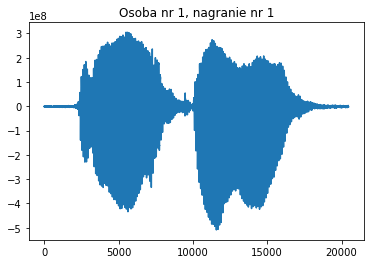

Nazwa obecnego pliku:  289516_25_K_10_3_RADIO.wav


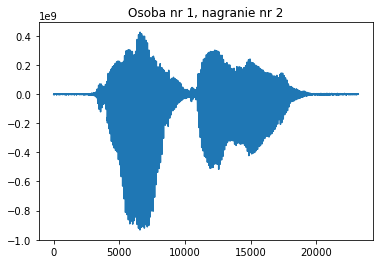

Nazwa obecnego pliku:  289516_25_K_16_4_RADIO.wav


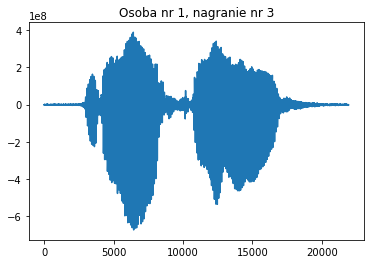

Nazwa obecnego pliku:  289516_25_K_22_1_RADIO.wav


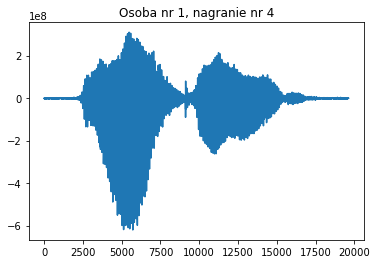

Nazwa obecnego pliku:  289540_23_K_13_2_RADIO.wav


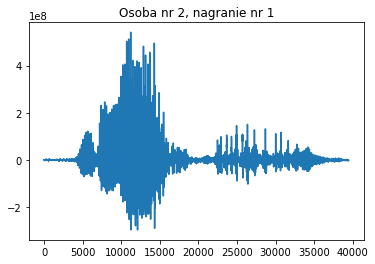

Nazwa obecnego pliku:  289540_23_K_18_3_RADIO.wav


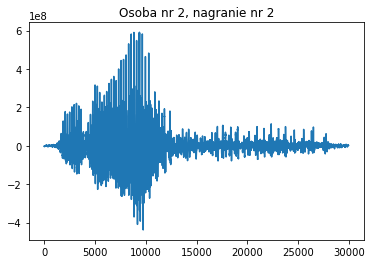

Nazwa obecnego pliku:  289540_23_K_22_4_RADIO.wav


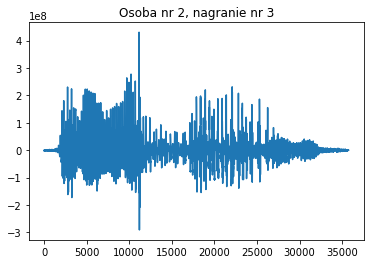

Nazwa obecnego pliku:  289540_23_K_9_1_RADIO.wav


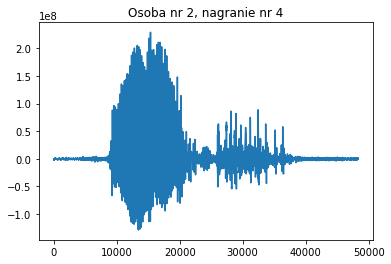

Nazwa obecnego pliku:  289550_23_K_18_2_RADIO.wav


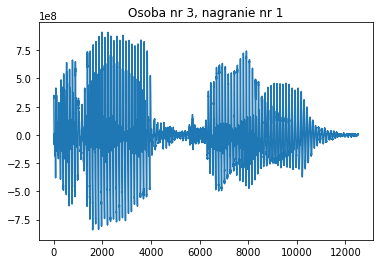

Nazwa obecnego pliku:  289550_23_K_23_3_RADIO.wav


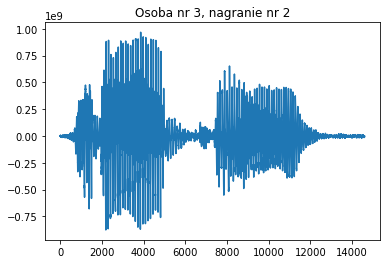

Nazwa obecnego pliku:  289550_23_K_23_4_RADIO.wav


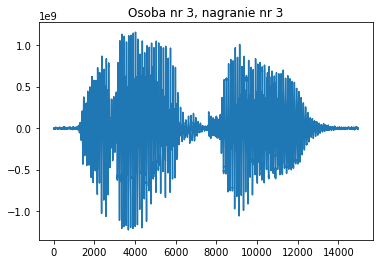

Nazwa obecnego pliku:  289550_23_K_9_1_RADIO.wav


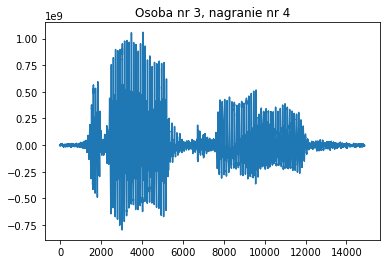

Nazwa obecnego pliku:  289556_24_K_11_1_RADIO.wav


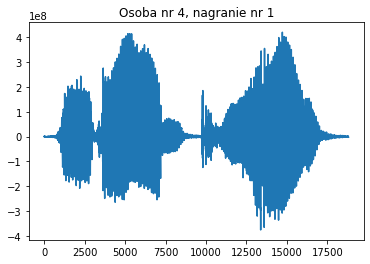

Nazwa obecnego pliku:  289556_24_K_15_2_RADIO.wav


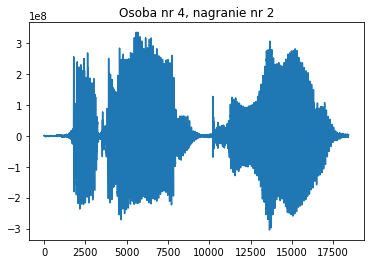

Nazwa obecnego pliku:  289556_24_K_19_3_RADIO.wav


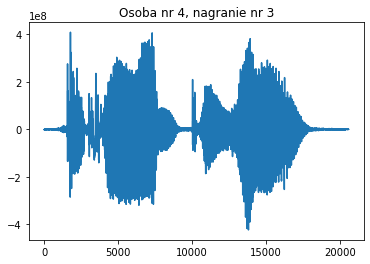

Nazwa obecnego pliku:  289556_24_K_23_4_RADIO.wav


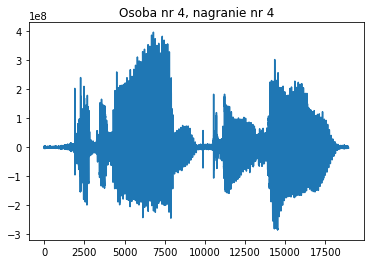

Nazwa obecnego pliku:  289592_24_K_12_1_RADIO.wav


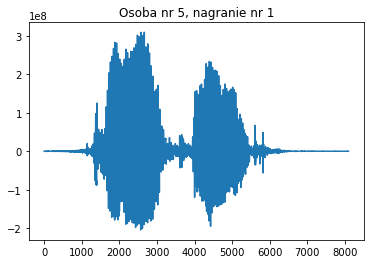

Nazwa obecnego pliku:  289592_24_K_15_2_RADIO.wav


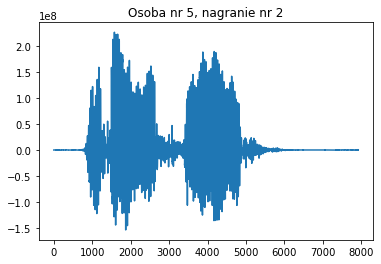

Nazwa obecnego pliku:  289592_24_K_19_3_RADIO.wav


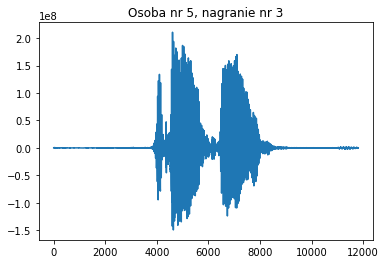

Nazwa obecnego pliku:  289592_24_K_7_4_RADIO.wav


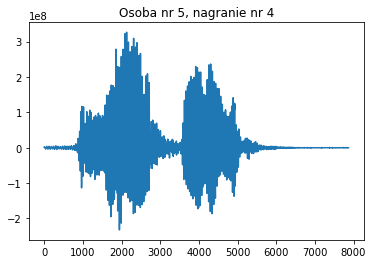

Nazwa obecnego pliku:  404907_23_K_11_1_RADIO.wav


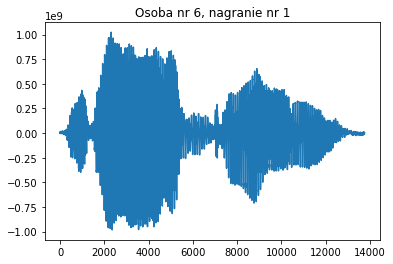

Nazwa obecnego pliku:  404907_23_K_14_2_RADIO.wav


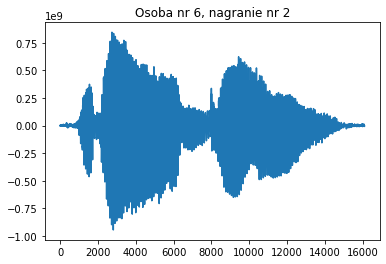

Nazwa obecnego pliku:  404907_23_K_16_3_RADIO.wav


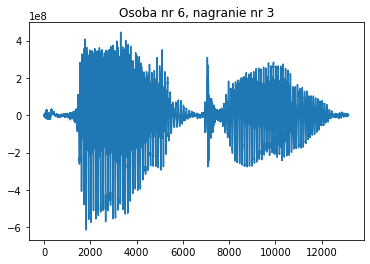

Nazwa obecnego pliku:  404907_23_K_20_4_RADIO.wav


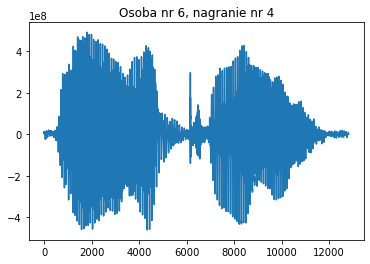

In [385]:
# Wyświetlanie wszystkich wersji danego słowa

nr_slowa = 15 # podaj wartość między 0 a 97
word_path = path + '/' + labels[nr_slowa]
jedno_slowo = []
for i in range(0, len(list_of_names)):
    person_filename = list_of_names[i]
    person_file_wav = files_wav_list[i]
    person_file_txt = files_txt_list[i]
    if os.path.isfile(word_path + '/' + person_filename + '_' + '{0}.wav'.format(labels[nr_slowa])) == True:
        new_filename = person_filename + '_' + labels[nr_slowa] + '.wav'
#         print("Etykieta: ", labels[0])
#         print("Ścieżka: ", word_path)
        print("Nazwa obecnego pliku: ", new_filename)
        person = wave.open(word_path + '/' + new_filename, 'rb')
        if person.getnframes() % 2 != 0:
            person_frames = person.readframes(person.getnframes()-1)
        else:
            person_frames = person.readframes(person.getnframes())
        person_frames = np.frombuffer(person_frames, dtype=int)
        jedno_slowo.append(person_frames)
        plt.figure()
        plt.plot(person_frames)
        text = "Osoba nr " + str(int(i / 4 + 1)) + ", nagranie nr " + str(int(i % 4 + 1))
        plt.title(text)
        plt.show()

In [362]:
# Liczenie parametrów zapisywanych do plików słów (w każdym pliku 24 wartości, kolejne osoby wypowiadające to samo słowo)
# Parametry:
# area (pole powierzchni z wartości bezwzględnych amplitud)
# zeros (gęstość przejść przez 0)
# squaresum (suma kwadratów amplitud)
# mean (średnia arytmetyczna amplitud)

area_folder_name = path + '/' + 'Area_słowa' + '/' # tworzenie folderu na wyniki danego parametru
zeros_folder_name = path + '/' + 'Zeros_słowa' + '/'
squaresum_folder_name = path + '/' + 'Squaresum_słowa' + '/'
mean_folder_name = path + '/' + 'Mean_słowa' + '/'
for j in range(98):
    print(j)
    labels = []
    if j > 0:
        for a in range(0, j):
            labels.append('')
    area_word = []
    zeros_word = []
    zeros_cnt = 0
    squaresum_word = []
    squaresum_cnt = 0
    squaresum_m = 0
    mean_word = []
    mean_cnt = 0    
    slowo = []
    for i in range(0, len(list_of_names)):
        filename = list_of_names[i]
        file_wav = files_wav_list[i]
        file_txt = files_txt_list[i]
        textfile = pd.read_csv(path + '/' + file_txt, sep = '\t', header = None)
        labels.append(str(textfile[2][j]))
        if labels[j] == 'nan':
            labels[j] = 'NA'
        labels[j] = labels[j].upper()
        if i == 0:
            print(labels[j])
        person_path = path + '/' + labels[j]
        # Sprawdź, czy istnieje plik o danej nazwie
        if os.path.isfile(person_path + '/' + filename + '_' + '{0}.wav'.format(labels[j])) == True:
            new_filename = filename + '_' + labels[j] + '.wav'
            person = wave.open(person_path + '/' + new_filename, 'rb')
            # Jeśli ilość ramek nieparzysta, to nie zadziała, więc wtedy wczytujemy wszystkie ramki oprócz ostatniej
            if person.getnframes() % 2 != 0:
                person_frames = person.readframes(person.getnframes()-1)
            else:
                person_frames = person.readframes(person.getnframes())
            person_frames = np.frombuffer(person_frames, dtype=int)
            slowo.append(person_frames)
            if os.path.isdir(area_folder_name) == False:
                os.mkdir(area_folder_name)
            if os.path.isdir(zeros_folder_name) == False:
                os.mkdir(zeros_folder_name)
            if os.path.isdir(squaresum_folder_name) == False:
                os.mkdir(squaresum_folder_name)
            if os.path.isdir(mean_folder_name) == False:
                os.mkdir(mean_folder_name)
            area_word.append(simps(np.abs(slowo[i])))
            for m in range(1, len(slowo[i])):
                if (slowo[i][m] <= 0 and slowo[i][m-1] > 0) or (slowo[i][m] >= 0 and slowo[i][m-1] < 0):
                    zeros_cnt += 1
            zeros_word.append(zeros_cnt) #liczone zera
            for n in range(0, len(slowo[i])):
                squaresum_m = int(slowo[i][n])*int(slowo[i][n])
                squaresum_cnt = squaresum_cnt + squaresum_m
            squaresum_word.append(squaresum_cnt)
            for o in range(0, len(slowo[i])):
                mean_cnt = mean_cnt + int(slowo[i][o])
            mean_cnt = mean_cnt/len(slowo[i])
            mean_word.append(mean_cnt)
                
    area_txt_person_filename = area_folder_name + 'area_' + labels[j] + '.txt'
    zeros_txt_person_filename = zeros_folder_name + 'zeros_' + labels[j] + '.txt'
    squaresum_txt_person_filename = squaresum_folder_name + 'squaresum_' + labels[j] + '.txt'
    mean_txt_person_filename = mean_folder_name + 'mean_' + labels[j] + '.txt'
    if os.path.isfile(area_txt_person_filename) == False:
        np.savetxt(area_txt_person_filename, area_word)
        print('Zapisano jako:', area_txt_person_filename)
    else:
        print('Plik', labels[j], 'z AREA już istnieje') 
    if os.path.isfile(zeros_txt_person_filename) == False:
        np.savetxt(zeros_txt_person_filename, zeros_word)
        print('Zapisano jako:', zeros_txt_person_filename)
    elif os.path.isfile(zeros_txt_person_filename) == True:
        print('Plik', labels[j], 'z ZEROS już istnieje') 
    if os.path.isfile(squaresum_txt_person_filename) == False:
        np.savetxt(squaresum_txt_person_filename, squaresum_word)
        print('Zapisano jako:', squaresum_txt_person_filename)
    elif os.path.isfile(squaresum_txt_person_filename) == True:
        print('Plik', labels[j], 'z SQUARESUM już istnieje')    
    if  os.path.isfile(mean_txt_person_filename) == False:
        np.savetxt(mean_txt_person_filename, mean_word)
        print('Zapisano jako:', mean_txt_person_filename)
    elif os.path.isfile(mean_txt_person_filename) == True:
        print('Plik', labels[j], 'z MEAN już istnieje')

0
OTWORZ
Plik OTWORZ z AREA już istnieje
Plik OTWORZ z ZEROS już istnieje
Plik OTWORZ z SQUARESUM już istnieje
Plik OTWORZ z MEAN już istnieje
1
WLACZ
Plik WLACZ z AREA już istnieje
Plik WLACZ z ZEROS już istnieje
Plik WLACZ z SQUARESUM już istnieje
Plik WLACZ z MEAN już istnieje
2
SWIATLO
Plik SWIATLO z AREA już istnieje
Plik SWIATLO z ZEROS już istnieje
Plik SWIATLO z SQUARESUM już istnieje
Plik SWIATLO z MEAN już istnieje
3
TELEWIZOR
Plik TELEWIZOR z AREA już istnieje
Plik TELEWIZOR z ZEROS już istnieje
Plik TELEWIZOR z SQUARESUM już istnieje
Plik TELEWIZOR z MEAN już istnieje
4
ZAMKNIJ
Plik ZAMKNIJ z AREA już istnieje
Plik ZAMKNIJ z ZEROS już istnieje
Plik ZAMKNIJ z SQUARESUM już istnieje
Plik ZAMKNIJ z MEAN już istnieje
5
KUCHNI
Plik KUCHNI z AREA już istnieje
Plik KUCHNI z ZEROS już istnieje
Plik KUCHNI z SQUARESUM już istnieje
Plik KUCHNI z MEAN już istnieje
6
NA
Plik NA z AREA już istnieje
Plik NA z ZEROS już istnieje
Plik NA z SQUARESUM już istnieje
Plik NA z MEAN już istnieje

In [364]:
# Współczynniki cepstralne MFCC
# Na podstawie: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
folder_path = path + '/' + 'MFCC'
if os.path.isdir(folder_path) == False:
    os.mkdir(folder_path)

for filename in list_of_names:

    mfcc_list = []
    
    for nr_word in range(0,98):
        path_word = path + "/" + labels[nr_word]

        # Wczytanie słowa
        if os.path.isfile(path_word + '/' + filename + '_' + labels[nr_word] + '.wav') == False:
            break
        sample_rate, signal = wf.read(path_word + '/' + filename + '_' + labels[nr_word] + '.wav')

        # Preemfaza
        pre_emphasis = 0.97 # parametr
        emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

        # Formowanie ramek
        frame_size = 0.025
        frame_stride = 0.01 # bo sygnał jest w ms
        frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate # zamiana z sekund na próbki
        signal_length = len(emphasized_signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Sprawdzanie czy jest chociaż jedna ramka

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(emphasized_signal, z) # Upewnianie się, że wszystkie ramki mają równą liczbę próbek bez obcinania jakichkolwiek próbek z oryginalnego sygnału

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]

        # Okienkowanie
        frames = frames * np.hamming(frame_length) # Hamming najczęściej stosowany w rozpoznaniu mowy

        # FFT i Power Spectrum // powstaje widmo liniowe
        NFFT = 512
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

        # Bank filtrów // powstaje widmo melowe
        nfilt = 40
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Konwersja Hz do Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Równo rozmieszczona skala Mel
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Konwersja Mel do Hz
        bin = np.floor((NFFT + 1) * hz_points / sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # lewe
            f_m = int(bin[m])             # centrum
            f_m_plus = int(bin[m + 1])    # prawe

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Stabilność numeryczna

        # Logarytmowanie
        filter_banks = 20 * np.log10(filter_banks)  # dB

        # Współczynniki cepstralne częstotliwości mel -- Mel-frequency Cepstral Coefficients (MFCCs)
        # DCT
        num_ceps = 12 # liczba współczynników - między 2 a 13
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
        
        # Zapis do pliku - słowo każdej osoby w osobnym
        file = folder_path + '/' + 'MFCC_' + filename + '_' + labels[nr_word] + '.txt'
        np.savetxt(file, mfcc)

In [365]:
# Ścieżki do plików z parametrami
path_area = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/Area_słowa'
path_mean = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/Mean_słowa'
path_squaresum = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/Squaresum_słowa'
path_zeros = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/Zeros_słowa'
path_mfcc = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/MFCC'

# Area
list_of_files = os.listdir(path_area)
list_of_names_area = []
for entry in list_of_files:
    list_of_names_area.append(entry[:-4])
files_txt_list_area = []
for filename in list_of_names_area:
    files_txt_list_area.append(filename + '.txt')

# Mean
list_of_files = os.listdir(path_mean)
list_of_names_mean = []
for entry in list_of_files:
    list_of_names_mean.append(entry[:-4])
files_txt_list_mean = []
for filename in list_of_names_mean:
    files_txt_list_mean.append(filename + '.txt')

# Squaresum
list_of_files = os.listdir(path_squaresum)
list_of_names_squaresum = []
for entry in list_of_files:
    list_of_names_squaresum.append(entry[:-4])
files_txt_list_squaresum = []
for filename in list_of_names_squaresum:
    files_txt_list_squaresum.append(filename + '.txt')
    
# Zeros
list_of_files = os.listdir(path_zeros)
list_of_names_zeros = []
for entry in list_of_files:
    list_of_names_zeros.append(entry[:-4])
files_txt_list_zeros = []
for filename in list_of_names_zeros:
    files_txt_list_zeros.append(filename + '.txt')

# MFCC
list_of_files = os.listdir(path_mfcc)
list_of_names_mfcc = []
for entry in list_of_files:
    list_of_names_mfcc.append(entry[:-4])
files_txt_list_mfcc = []
for filename in list_of_names_mfcc:
    files_txt_list_mfcc.append(filename + '.txt')

print('Obecne pliki:')

for i in range(3):
    print(files_txt_list_area[i])
    print(files_txt_list_mean[i])
    print(files_txt_list_squaresum[i])
    print(files_txt_list_zeros[i])
    print(files_txt_list_mfcc[i])
print ('i inne')
print('Liczba plików: ', len(list_of_names_area)+len(list_of_names_mean)+len(list_of_names_squaresum)+
     len(list_of_names_zeros)+len(list_of_names_mfcc))

Obecne pliki:
area_ALARM.txt
mean_ALARM.txt
squaresum_ALARM.txt
zeros_ALARM.txt
MFCC_289516_25_K_01_2_ALARM.txt
area_BRAME.txt
mean_BRAME.txt
squaresum_BRAME.txt
zeros_BRAME.txt
MFCC_289516_25_K_01_2_BRAME.txt
area_BUDZIK.txt
mean_BUDZIK.txt
squaresum_BUDZIK.txt
zeros_BUDZIK.txt
MFCC_289516_25_K_01_2_BUDZIK.txt
i inne
Liczba plików:  2744


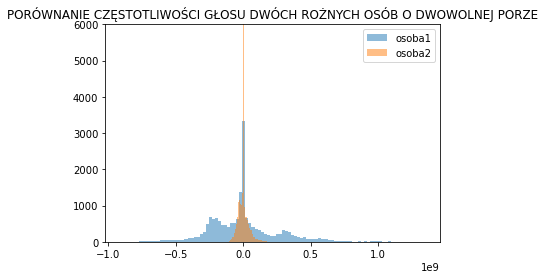

Dominująca częstotliwość osoby pierwszej: 1345342729.0
Dominująca częstotliwość osoby drugiej: 177867418.0


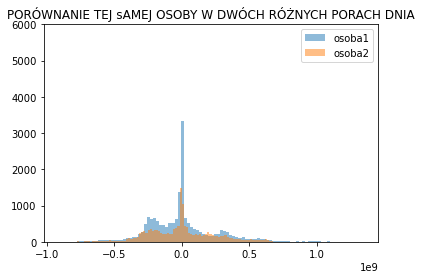

In [378]:
# Histogramy
# Porównanie dwóch osób o dowolnej godzinie

osoba1 = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/BRAME/289550_23_K_9_1_BRAME.wav'
osoba2 = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/BRAME/289540_23_K_9_1_BRAME.wav'
osoba_03 = []
word1 = wave.open(osoba1, 'rb')

if word1.getnframes() % 2 != 0:
    word1_frames = word1.readframes(word1.getnframes()-1)
else:
    word1_frames = word1.readframes(word1.getnframes())
word1_frames = np.frombuffer(word1_frames, dtype=int) #amplitudy
osoba_03.append(word1_frames)

word2 = wave.open(osoba2, 'rb')

if word2.getnframes() % 2 != 0:
    word2_frames = word2.readframes(word2.getnframes()-1)
else:
    word2_frames = word2.readframes(word2.getnframes())
word2_frames = np.frombuffer(word2_frames, dtype=int) #amplitudy
osoba_03.append(word2_frames)

word1_frame = np.array(word1_frames)
word2_frame = np.array(word2_frames)

word1_frame = word1_frame[0:19000]
word2_frame = word2_frame[0:19000]

plt.figure()
plt.title('PORÓWNANIE CZĘSTOTLIWOŚCI GŁOSU DWÓCH ROŻNYCH OSÓB O DWOWOLNEJ PORZE')
y1,x1,_ = plt.hist(word1_frames,bins=100,alpha=0.5,label='osoba1')
y2,x2,_ = plt.hist(word2_frames,bins=100,alpha=0.5,label='osoba2')
plt.ylim([0,6000])
plt.legend()
plt.show()

# Częstotliwości dominujące głosu

# Różne osoby:
print('Dominująca częstotliwość osoby pierwszej:', x1.max())
print('Dominująca częstotliwość osoby drugiej:', x2.max())


# Porównanie tego samego słowa o innej godzinie dla tej samej osoby

osoba1 = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/BRAME/289550_23_K_9_1_BRAME.wav'
osoba2 = 'C:/Dysk D/STUDIA/Eksploracja danych biomedycznych/Nagrania/BRAME/289550_23_K_18_2_BRAME.wav'
osoba_03 = []
word1 = wave.open(osoba1, 'rb')
        # Jeśli ilość ramek nieparzysta, to nie zadziała, więc wtedy wczytujemy wszystkie ramki oprócz ostatniej
if word1.getnframes() % 2 != 0:
    word1_frames = word1.readframes(word1.getnframes()-1)
else:
    word1_frames = word1.readframes(word1.getnframes())
word1_frames = np.frombuffer(word1_frames, dtype=int) #amplitudy
osoba_03.append(word1_frames)

word2 = wave.open(osoba2, 'rb')
        # Jeśli ilość ramek nieparzysta, to nie zadziała, więc wtedy wczytujemy wszystkie ramki oprócz ostatniej
if word2.getnframes() % 2 != 0:
    word2_frames = word2.readframes(word2.getnframes()-1)
else:
    word2_frames = word2.readframes(word2.getnframes())
word2_frames = np.frombuffer(word2_frames, dtype=int) #amplitudy
osoba_03.append(word2_frames)

word1_frame = np.array(word1_frames)
word2_frame = np.array(word2_frames)

word1_frame = word1_frame[0:19000]
word2_frame = word2_frame[0:19000]


plt.figure()
plt.title("PORÓWNANIE TEJ sAMEJ OSOBY W DWÓCH RÓŻNYCH PORACH DNIA")
plt.hist(word1_frames,bins=100,alpha=0.5,label='osoba1')
plt.hist(word2_frames,bins=100,alpha=0.5,label='osoba2')
plt.ylim([0,6000])
plt.legend()
plt.show()

In [379]:
# Etykiety
labels = []
for i in range(98):
    file_txt = files_txt_list[0]
    textfile = pd.read_csv(path + '/' + file_txt, sep = '\t', header = None)
    labels.append(str(textfile[2][i]))
    if labels[i] == 'nan':
        labels[i] = 'NA'
    labels[i] = labels[i].upper()
#     if i < 10:
#         print(i, labels[i])
labels.sort()
print('Etykiety alfabetycznie: ', labels)
# print('i inne')

# Wczytanie wartości parametrów

# Area
area_param = []
for file_txt in files_txt_list_area:
    textfile_area = pd.read_csv(path_area + '/' + file_txt, sep = '\t', header = None)
    area_param.append(textfile_area)
    
# Mean
mean_param = []
for file_txt in files_txt_list_mean:
    textfile_mean = pd.read_csv(path_mean + '/' + file_txt, sep = '\t', header = None)
    mean_param.append(textfile_mean)

# Squaresum
squaresum_param = []
for file_txt in files_txt_list_squaresum:
    textfile_squaresum = pd.read_csv(path_squaresum + '/' + file_txt, sep = '\t', header = None)
    squaresum_param.append(textfile_squaresum)
    
# Zeros
zeros_param = []
for file_txt in files_txt_list_zeros:
    textfile_zeros = pd.read_csv(path_zeros + '/' + file_txt, sep = '\t', header = None)
    zeros_param.append(textfile_zeros)

# MFCC
mfcc_param = []
for file_txt in files_txt_list_mfcc:
    textfile_mfcc = pd.read_csv(path_mfcc + '/' + file_txt, sep = ' ', header = None)
    mfcc_param.append(textfile_mfcc)
    

Etykiety alfabetycznie:  ['ALARM', 'BRAME', 'BUDZIK', 'CISZEJ', 'CZAJNIK', 'CZTERY', 'DO', 'DOMU', 'DRZWI', 'DWA', 'EKSPRES', 'GABINECIE', 'GARAZ', 'GARAZU', 'GARDEROBIE', 'GLOSNIEJ', 'HERBATE', 'JEDEN', 'KANAL', 'KAWE', 'KLIMATYZACJE', 'KOMPUTER', 'KORYTARZU', 'KUCHNI', 'KWIATKI', 'LAMPKE', 'LAZIENCE', 'LAZIENKI', 'LODOWKE', 'LOZKO', 'MUZYKE', 'NA', 'O', 'ODBLOKUJ', 'ODSLON', 'OGRZEWANIE', 'OKAP', 'OKNA', 'OKNO', 'OPUSC', 'OSWIETLENIE', 'OTWORZ', 'PALNIK', 'PIEKARNIK', 'PIWNICY', 'PODAJ', 'PODGLOSNIJ', 'PODLEJ', 'PODNIES', 'POKOJU', 'PRALKE', 'PROGRAM', 'PRZEDPOKOJU', 'PRZYCIEMNIJ', 'PRZYGOTUJ', 'RADIO', 'ROLETY', 'ROZJASNIJ', 'SALONIE', 'SCHODACH', 'SCISZ', 'SPUSC', 'STACJE', 'STOPIEN', 'STOPNI', 'STRYCHU', 'SUSZARKE', 'SWIATLO', 'SYPIALNI', 'TARASIE', 'TELEWIZOR', 'TEMPERATURE', 'TRZY', 'UCHYL', 'USTAW', 'W', 'WEJSCIOWE', 'WLACZ', 'WODE', 'WODY', 'WYLACZ', 'Z', 'ZABLOKUJ', 'ZADZWON', 'ZAGOTUJ', 'ZAKREC', 'ZALUZJE', 'ZAMKNIJ', 'ZAPAL', 'ZASLON', 'ZASUN', 'ZEWNATRZ', 'ZGAS', 'ZMIEN', 

In [380]:
# Tworzenie tabeli z danymi (wszystkie słowa)
temp_list = []

for i in range(len(labels)):
    for j in range(len(list_of_names)):
        temp_list.append([area_param[i][0][j], mean_param[i][0][j], squaresum_param[i][0][j], zeros_param[i][0][j],
                          labels[i]])

data_table = pd.DataFrame(temp_list, columns=['Area', 'Mean', 'Square_sum',
                                              'Zero_crossing_density', 'Label'])
data_table

,Area,Mean,Square_sum,Zero_crossing_density,Label
0,1.389708e+12,-6.239246e+04,3.334319e+20,911.0,ALARM
1,1.353984e+12,-1.309208e+06,6.960006e+20,2668.0,ALARM
2,1.325710e+12,-1.353242e+06,9.895265e+20,3960.0,ALARM
3,1.181219e+12,-1.346650e+06,1.133683e+21,4899.0,ALARM
4,1.462367e+12,-3.381891e+05,1.278582e+21,6087.0,ALARM
...,...,...,...,...,...
2347,1.742905e+11,-1.173228e+05,6.450718e+21,74868.0,ZWIEKSZ
2348,1.207129e+12,-1.015347e+05,7.034856e+21,78499.0,ZWIEKSZ
2349,1.291088e+12,1.531369e+04,7.416939e+21,81768.0,ZWIEKSZ
2350,1.023934e+12,-1.605737e+05,7.726963e+21,85965.0,ZWIEKSZ


In [368]:
temp_list = []
for i in range(len(labels)):
    for j in range(len(list_of_names)):
        temp_list.append([area_param[i][0][j], mean_param[i][0][j], squaresum_param[i][0][j], zeros_param[i][0][j], i])

# Stworzenie tabeli z danymi
data_table = pd.DataFrame(temp_list, columns=['Area', 'Mean', 'Square_sum',
                                              'Zero_crossing_density', 'Label'])
data_table

,Area,Mean,Square_sum,Zero_crossing_density,Label
0,1.389708e+12,-6.239246e+04,3.334319e+20,911.0,0
1,1.353984e+12,-1.309208e+06,6.960006e+20,2668.0,0
2,1.325710e+12,-1.353242e+06,9.895265e+20,3960.0,0
3,1.181219e+12,-1.346650e+06,1.133683e+21,4899.0,0
4,1.462367e+12,-3.381891e+05,1.278582e+21,6087.0,0
...,...,...,...,...,...
2347,1.742905e+11,-1.173228e+05,6.450718e+21,74868.0,97
2348,1.207129e+12,-1.015347e+05,7.034856e+21,78499.0,97
2349,1.291088e+12,1.531369e+04,7.416939e+21,81768.0,97
2350,1.023934e+12,-1.605737e+05,7.726963e+21,85965.0,97


In [369]:
# Ustawienie randomowej kolejności wierszy
rand_data_table = data_table.sample(frac=1)
rand_data_table

,Area,Mean,Square_sum,Zero_crossing_density,Label
1800,7.238075e+11,-1.355665e+05,1.901802e+20,618.0,75
282,2.741135e+11,-6.058214e+04,1.170965e+22,41299.0,11
332,1.102314e+12,-2.261774e+05,8.986943e+21,34009.0,13
2158,1.217316e+12,-8.441739e+04,1.177860e+22,78246.0,89
351,2.131528e+12,-2.212121e+05,1.723853e+22,26919.0,14
...,...,...,...,...,...
1115,1.387118e+12,-1.877577e+06,1.160702e+22,27976.0,46
1442,8.225797e+11,-1.227426e+06,4.101076e+20,14437.0,60
1318,1.103155e+12,-1.338865e+05,1.176439e+22,56893.0,54
2333,1.417574e+12,-3.394413e+05,1.817993e+21,21812.0,97


In [371]:
# Na podstawie https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=en

# Podzielenie danych na uczące i testowe
train_data, test_data = train_test_split(rand_data_table, test_size=0.25)
train_data, val_data = train_test_split(train_data, test_size=0.25)

# Rozdzielenie parametrów i etykiet
train_features = train_data[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
train_labels = train_data['Label']
val_features = val_data[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
val_labels = val_data['Label']
test_features = test_data[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
test_labels = test_data['Label']

rand_train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_features), train_labels))
rand_val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_features), val_labels))
rand_test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_features), test_labels))

data_batch_size = 16
train_batch = rand_train_dataset.batch(data_batch_size)
val_batch = rand_val_dataset.batch(data_batch_size)
test_batch = rand_test_dataset.batch(data_batch_size)
print('Wielkość zbioru uczącego:', len(rand_train_dataset))
print('Wielkość zbioru walidacyjnego:', len(rand_val_dataset))
print('Wielkość zbioru testowego:', len(rand_test_dataset))

Wielkość zbioru uczącego: 1323
Wielkość zbioru walidacyjnego: 441
Wielkość zbioru testowego: 588


In [372]:
# Ustalenie numerycznych kolumn z danymi
feat_columns = []
feat_area = feature_column.numeric_column('Area')
feat_columns.append(feat_area)
feat_mean = feature_column.numeric_column('Mean')
feat_columns.append(feat_mean)
feat_squaresum = feature_column.numeric_column('Square_sum')
feat_columns.append(feat_squaresum)
feat_zeros = feature_column.numeric_column('Zero_crossing_density')
feat_columns.append(feat_zeros)

feature_layer = tf.keras.layers.DenseFeatures(feat_columns)


In [373]:
# Zbudowanie i uczenie modelu
model_AI = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model_AI.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_AI.fit(train_batch,
          validation_data=val_batch,
          epochs=10)


Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
77/83 [==========================>...] - ETA: 0s - loss: nan - accuracy: 0.0122                          WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Area': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'Mean': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'Square_sum': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Zero_crossing_density': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>}
Consider rewriting this model with the Functional API.
83/83 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0121 - val_loss: nan - val_accuracy: 0.0091
Epoch 2/10
83/83 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0121 - val_loss: nan - val_accuracy: 0.0091
Epoch 3/10
83/83 [=======================

In [393]:
# Wyznaczenie dokładności rozpoznawania
loss, accuracy = model_AI.evaluate(test_batch)
print("Dokładność klasyfikacji:", (round(10000*accuracy))/100, '%')


37/37 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0068
Dokładność klasyfikacji: 0.68 %


In [394]:
# Tworzenie tabeli z danymi (wszystkie słowa jednej osoby)
temp_list_1 = []

for i in range(len(labels)):
    for j in range(4):
        temp_list_1.append([area_param[i][0][j], mean_param[i][0][j], squaresum_param[i][0][j], zeros_param[i][0][j], i])

# Stworzenie tabeli z danymi
data_table_1 = pd.DataFrame(temp_list_1, columns=['Area', 'Mean', 'Square_sum',
                                              'Zero_crossing_density', 'Label'])

# Ustawienie randomowej kolejności wierszy
rand_data_table_1 = data_table_1.sample(frac=1)

# Podzielenie danych na uczące i testowe
train_data_1, test_data_1 = train_test_split(rand_data_table_1, test_size=0.25)
train_data_1, val_data_1 = train_test_split(train_data_1, test_size=0.25)
train_features_1 = train_data_1[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
train_labels_1 = train_data_1['Label']
val_features_1 = val_data_1[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
val_labels_1 = val_data_1['Label']
test_features_1 = test_data_1[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
test_labels_1 = test_data_1['Label']

rand_train_dataset_1 = tf.data.Dataset.from_tensor_slices((dict(train_features_1), train_labels_1))
rand_val_dataset_1 = tf.data.Dataset.from_tensor_slices((dict(val_features_1), val_labels_1))
rand_test_dataset_1 = tf.data.Dataset.from_tensor_slices((dict(test_features_1), test_labels_1))

train_batch_1 = rand_train_dataset_1.batch(data_batch_size)
val_batch_1 = rand_val_dataset_1.batch(data_batch_size)
test_batch_1 = rand_test_dataset_1.batch(data_batch_size)
print('Wielkość zbioru uczącego:', len(rand_train_dataset_1))
print('Wielkość zbioru walidacyjnego:', len(rand_val_dataset_1))
print('Wielkość zbioru testowego:', len(rand_test_dataset_1))

# Dopasowanie kolumn
feat_columns_1 = []
feat_area_1 = feature_column.numeric_column('Area')
feat_columns_1.append(feat_area_1)
feat_mean_1 = feature_column.numeric_column('Mean')
feat_columns_1.append(feat_mean_1)
feat_squaresum_1 = feature_column.numeric_column('Square_sum')
feat_columns_1.append(feat_squaresum_1)
feat_zeros_1 = feature_column.numeric_column('Zero_crossing_density')
feat_columns_1.append(feat_zeros_1)

feature_layer_1 = tf.keras.layers.DenseFeatures(feat_columns_1)

# Uczenie modelu
model_AI_1 = tf.keras.Sequential([
  feature_layer_1,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model_AI_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_AI_1.fit(train_batch_1,
          validation_data=val_batch_1,
          epochs=10)

# Sprawdzenie modelu na danych testowych
loss_1, accuracy_1 = model_AI_1.evaluate(test_batch_1)
print("Dokładność klasyfikacji:", (round(10000*accuracy_1))/100, '%')

Wielkość zbioru uczącego: 220
Wielkość zbioru walidacyjnego: 74
Wielkość zbioru testowego: 98
Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/14 [=>............................] - ETA: 11s - loss: 2130503239021371588608.0000 - accuracy: 0.0625WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Area': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'Mean': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'Square_sum': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Zero_crossing_density': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>}
Consider rewriting this model with the Functional API.
14/14 [==============================] - 1s 23ms/step - loss: nan - accuracy: 0.0091 - val_loss: nan - val_accuracy: 0.0135
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: nan - acc

In [391]:
# Tworzenie tabeli z danymi (dwa słowa jednej osoby)
temp_list_2 = []

for i in range(2):
    for j in range(4):
        temp_list_2.append([area_param[i][0][j], mean_param[i][0][j], squaresum_param[i][0][j], zeros_param[i][0][j], i])

# Stworzenie tabeli z danymi
data_table_2 = pd.DataFrame(temp_list_2, columns=['Area', 'Mean', 'Square_sum',
                                              'Zero_crossing_density', 'Label'])

# Ustawienie randomowej kolejności wierszy
rand_data_table_2 = data_table_2.sample(frac=1)

# Podzielenie danych na uczące i testowe
train_data_2, test_data_2 = train_test_split(rand_data_table_2, test_size=0.25)
train_data_2, val_data_2 = train_test_split(train_data_2, test_size=0.25)
train_features_2 = train_data_2[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
train_labels_2 = train_data_2['Label']
val_features_2 = val_data_2[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
val_labels_2 = val_data_2['Label']
test_features_2 = test_data_2[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
test_labels_2 = test_data_2['Label']

rand_train_dataset_2 = tf.data.Dataset.from_tensor_slices((dict(train_features_2), train_labels_2))
rand_val_dataset_2 = tf.data.Dataset.from_tensor_slices((dict(val_features_2), val_labels_2))
rand_test_dataset_2 = tf.data.Dataset.from_tensor_slices((dict(test_features_2), test_labels_2))

train_batch_2 = rand_train_dataset_2.batch(data_batch_size)
val_batch_2 = rand_val_dataset_2.batch(data_batch_size)
test_batch_2 = rand_test_dataset_2.batch(data_batch_size)
print('Wielkość zbioru uczącego:', len(rand_train_dataset_2))
print('Wielkość zbioru walidacyjnego:', len(rand_val_dataset_2))
print('Wielkość zbioru testowego:', len(rand_test_dataset_2))

# Dopasowanie kolumn
feat_columns_2 = []
feat_area_2 = feature_column.numeric_column('Area')
feat_columns_2.append(feat_area_2)
feat_mean_2 = feature_column.numeric_column('Mean')
feat_columns_2.append(feat_mean_2)
feat_squaresum_2 = feature_column.numeric_column('Square_sum')
feat_columns_2.append(feat_squaresum_2)
feat_zeros_2 = feature_column.numeric_column('Zero_crossing_density')
feat_columns_2.append(feat_zeros_2)

feature_layer_2 = tf.keras.layers.DenseFeatures(feat_columns_2)

# Uczenie modelu
model_AI_2 = tf.keras.Sequential([
  feature_layer_2,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model_AI_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_AI_1.fit(train_batch_2,
          validation_data=val_batch_2,
          epochs=10)

# Sprawdzenie modelu na danych testowych
loss_2, accuracy_2 = model_AI_2.evaluate(test_batch_2)
print("Dokładność klasyfikacji:", (round(10000*accuracy_2))/100, '%')

Wielkość zbioru uczącego: 4
Wielkość zbioru walidacyjnego: 2
Wielkość zbioru testowego: 2
Epoch 1/10
1/1 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 31ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - 

In [388]:
# Tworzenie tabeli z danymi (dwa słowa wszystkich osób)
temp_list_3 = []

for i in range(2):
    for j in range(len(list_of_names)):
        temp_list_3.append([area_param[i][0][j], mean_param[i][0][j], squaresum_param[i][0][j], zeros_param[i][0][j], i])

# Stworzenie tabeli z danymi
data_table_3 = pd.DataFrame(temp_list_3, columns=['Area', 'Mean', 'Square_sum',
                                              'Zero_crossing_density', 'Label'])

# Ustawienie randomowej kolejności wierszy
rand_data_table_3 = data_table_3.sample(frac=1)

# Podzielenie danych na uczące i testowe
train_data_3, test_data_3 = train_test_split(rand_data_table_3, test_size=0.25)
train_data_3, val_data_3 = train_test_split(train_data_3, test_size=0.25)
train_features_3 = train_data_3[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
train_labels_3 = train_data_3['Label']
val_features_3 = val_data_3[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
val_labels_3 = val_data_3['Label']
test_features_3 = test_data_3[['Area', 'Mean', 'Square_sum', 'Zero_crossing_density']]
test_labels_3 = test_data_3['Label']

rand_train_dataset_3 = tf.data.Dataset.from_tensor_slices((dict(train_features_3), train_labels_3))
rand_val_dataset_3 = tf.data.Dataset.from_tensor_slices((dict(val_features_3), val_labels_3))
rand_test_dataset_3 = tf.data.Dataset.from_tensor_slices((dict(test_features_3), test_labels_3))

train_batch_3 = rand_train_dataset_3.batch(data_batch_size)
val_batch_3 = rand_val_dataset_3.batch(data_batch_size)
test_batch_3 = rand_test_dataset_3.batch(data_batch_size)
print('Wielkość zbioru uczącego:', len(rand_train_dataset_3))
print('Wielkość zbioru walidacyjnego:', len(rand_val_dataset_3))
print('Wielkość zbioru testowego:', len(rand_test_dataset_3))

# Dopasowanie kolumn
feat_columns_3 = []
feat_area_3 = feature_column.numeric_column('Area')
feat_columns_3.append(feat_area_3)
feat_mean_3 = feature_column.numeric_column('Mean')
feat_columns_3.append(feat_mean_3)
feat_squaresum_3 = feature_column.numeric_column('Square_sum')
feat_columns_3.append(feat_squaresum_3)
feat_zeros_3 = feature_column.numeric_column('Zero_crossing_density')
feat_columns_3.append(feat_zeros_3)

feature_layer_3 = tf.keras.layers.DenseFeatures(feat_columns_3)

# Uczenie modelu
model_AI_3 = tf.keras.Sequential([
  feature_layer_3,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model_AI_3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_AI_3.fit(train_batch_3,
          validation_data=val_batch_3,
          epochs=10)

# Sprawdzenie modelu na danych testowych
loss_3, accuracy_3 = model_AI_3.evaluate(test_batch_3)
print("Dokładność klasyfikacji:", (round(10000*accuracy_3))/100, '%')


Wielkość zbioru uczącego: 27
Wielkość zbioru walidacyjnego: 9
Wielkość zbioru testowego: 12
Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/2 [==============>...............] - ETA: 1s - loss: 75667528206428143616.0000 - accuracy: 0.4375WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Area': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'Mean': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'Square_sum': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Zero_crossing_density': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>}
Consider rewriting this model with the Functional API.
2/2 [==============================] - 2s 363ms/step - loss: nan - accuracy: 0.4815 - val_loss: nan - val_accuracy: 0.4444
Epoch 2/10
2/2 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.